In [3]:
using VCFTools
using Plots
using DelimitedFiles
using Statistics
using LaTeXStrings

## 1000 genomes

Note the original 1000 genomes data have been filtered for >5 minor allele counts. That's why the $r^2$ here is so high.

In [ ]:
# computes minor allele frequencies for reference panel
chr = 20 
ref = "ref.chr$chr.vcf.gz"
records, samples, lines, missings_by_sample, missings_by_record,
    maf_by_record, minorallele_by_record, hwe_by_record = gtstats(ref)
writedlm("chr$chr.maf", maf_by_record)

chr = 10
ref = "ref.chr$chr.vcf.gz"
records, samples, lines, missings_by_sample, missings_by_record,
    maf_by_record, minorallele_by_record, hwe_by_record = gtstats(ref)
writedlm("chr$chr.maf", maf_by_record)

In [5]:
"""
Computes r2 for SNPs that have minor allele counts between a certain range specified in `maf_bins`.
"""
function compute_r2_by_maf(
    minor_allele_count::AbstractVector,
    Xtrue::AbstractMatrix,
    Xtest::AbstractMatrix;
    verbose::Bool = false
    )
    maf_bins = [(2, 5), (8, 8), (16, 16), (30, 34), (60, 68), (120, 130),
        (250, 260), (500, 520), (1000, 1100), (2000, 2100)] # min/max
    r2 = zeros(length(maf_bins))
    xtrue = Vector{Vector{Float64}}()
    ximpute = Vector{Vector{Float64}}()
    for (i, mac) in enumerate(maf_bins)
        idx = findall(x -> mac[1] ≤ x ≤ mac[2], minor_allele_count)
        length(idx) == 0 && continue
        for j in idx
            push!(xtrue, @view(Xtrue[:, j]))
            push!(ximpute, @view(Xtest[:, j]))
        end
        r2[i] = abs2(cor(vcat(xtrue...), vcat(ximpute...)))
        verbose && println("macbin = $mac has $(length(idx)) matches and r2 = $(r2[i])")
    end
    return r2
end

compute_r2_by_maf

## Chromosome 20

In [6]:
chr = 20
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.imputed.chr$chr.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel")
Xbeagle = convert_ds(Float64, beagle, msg="importing Xbeagle");
Xmmac4 = convert_ds(Float64, mmac4, msg="importing Xmmac")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 3 : 7
Ximp5 = Vector{Matrix{Float64}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_ds(Float64, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks ")
end
Ximp5 = hcat(Ximp5...);

importing Xbeagle100%|██████████████████████████████████| Time: 0:00:12
importing Xmmac100%|████████████████████████████████████| Time: 0:00:13


macbin = (2, 5) has 48038 matches and r2 = 0.694968226027305
macbin = (8, 8) has 22870 matches and r2 = 0.7299272432109972
macbin = (16, 16) has 9077 matches and r2 = 0.7367448397037084
macbin = (30, 34) has 19053 matches and r2 = 0.8443180207109771
macbin = (60, 68) has 13840 matches and r2 = 0.8850529390761979
macbin = (120, 130) has 6010 matches and r2 = 0.8977924635621851
macbin = (250, 260) has 2266 matches and r2 = 0.9075188099571595
macbin = (500, 520) has 2319 matches and r2 = 0.9256500665335996
macbin = (1000, 1100) has 7214 matches and r2 = 0.9550777002852778
macbin = (2000, 2100) has 5676 matches and r2 = 0.9627104384622175


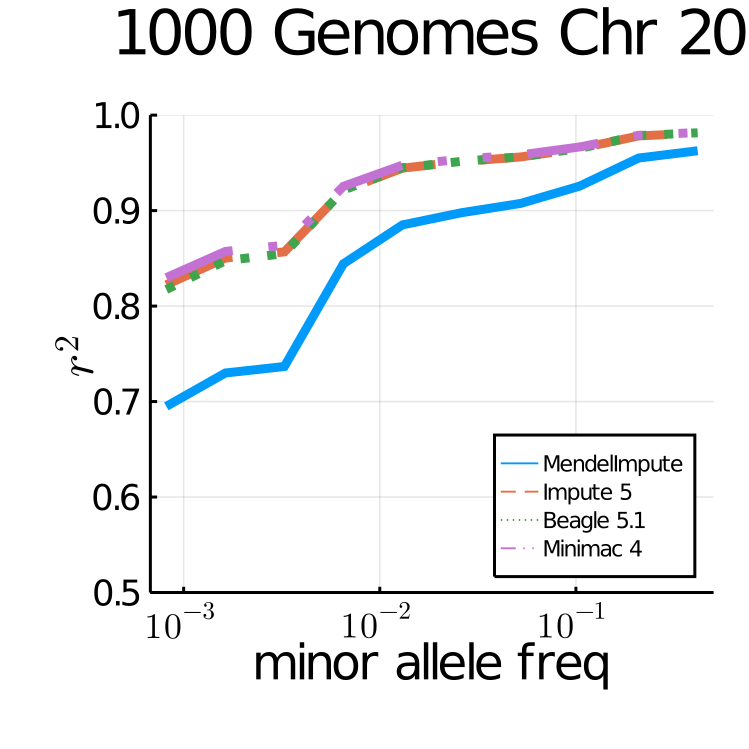

In [21]:
chr = 20
mafs = vec(readdlm("chr$chr.maf"))
n = nsamples("ref.chr$chr.vcf.gz")
minor_allele_count = mafs .* 2n
maf_bins = [2^i for i in 2:11]
xticks = ([1e-3, 1e-2, 1e-1], [latexstring("\$10^{-3}\$"),latexstring("\$10^{-2}\$"), latexstring("\$10^{-1}\$")])

r2_mendel = compute_r2_by_maf(minor_allele_count, Xtrue, Xmendel, verbose=true)
r2_impute5 = compute_r2_by_maf(minor_allele_count, Xtrue, Ximp5)
r2_beagle5 = compute_r2_by_maf(minor_allele_count, Xtrue, Xbeagle)
r2_mimimac4 = compute_r2_by_maf(minor_allele_count, Xtrue, Xmmac4)
sleep(1)

chr20_plt = plot(maf_bins ./ 2n, r2_mendel,label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="minor allele freq", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=xticks, dpi=300, size=(250, 250), ylim=(0.5, 1),
    title="1000 Genomes Chr 20",legendfontsize=5)
plot!(maf_bins ./ 2n, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash,legendfontsize=5)
plot!(maf_bins ./ 2n, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot,legendfontsize=5)
plot!(maf_bins ./ 2n, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdotdot,legendfontsize=5)

savefig(chr20_plt, "chr$chr.maf_plt.png")
display("image/png", read("chr$chr.maf_plt.png"))

## Chromosome 10

In [22]:
chr = 10
truth  = "target.chr$chr.full.vcf.gz"
mendel = "mendel.imputed.chr$chr.vcf.gz"
beagle = "beagle.imputed.chr$chr.vcf.gz"
mmac4  = "minimac4.chr$chr.result.dose.vcf.gz"

# isfile(truth) && isfile(mendel) && isfile(beagle) && isfile(mmac4) || error("file doens't exist!")

Xtrue = convert_gt(UInt8, truth, msg="importing Xtrue ")
Xmendel = convert_gt(UInt8, mendel, msg="importing Xmendel ")
Xbeagle = convert_ds(Float32, beagle, msg="importing Xbeagle ")
Xmmac4 = convert_ds(Float32, mmac4, msg="importing Xmmac ")
n, p = size(Xtrue)

# need to import each chunk of impute5 result separately
chunks = chr == 20 ? 3 : 7
Ximp5 = Vector{Matrix{Float32}}(undef, chunks)
for i in 1:chunks
    Ximp5[i] = convert_ds(Float32, "impute5.chr$chr.result.chunk$i.vcf.gz", msg="importing Ximp5 $i / $chunks ")
end
Ximp5 = hcat(Ximp5...);

importing Xtrue 100%|███████████████████████████████████| Time: 0:00:11
importing Xmendel 100%|█████████████████████████████████| Time: 0:00:12
importing Xbeagle 100%|█████████████████████████████████| Time: 0:00:30
importing Xmmac 100%|███████████████████████████████████| Time: 0:00:32
importing Ximp5 1 / 7 100%|█████████████████████████████| Time: 0:00:07
importing Ximp5 2 / 7 100%|█████████████████████████████| Time: 0:00:05
importing Ximp5 4 / 7 100%|█████████████████████████████| Time: 0:00:06


macbin = (2, 5) has 107398 matches and r2 = 0.6672728636834627
macbin = (8, 8) has 50606 matches and r2 = 0.7165606529137392
macbin = (16, 16) has 20608 matches and r2 = 0.7596442587680872
macbin = (30, 34) has 41622 matches and r2 = 0.8591695533066958
macbin = (60, 68) has 29163 matches and r2 = 0.9067152041738842
macbin = (120, 130) has 15301 matches and r2 = 0.9206547178471435
macbin = (250, 260) has 5775 matches and r2 = 0.9286336639545805
macbin = (500, 520) has 5319 matches and r2 = 0.9382971089950348
macbin = (1000, 1100) has 16821 matches and r2 = 0.9601500288190252
macbin = (2000, 2100) has 12214 matches and r2 = 0.9653783860740348


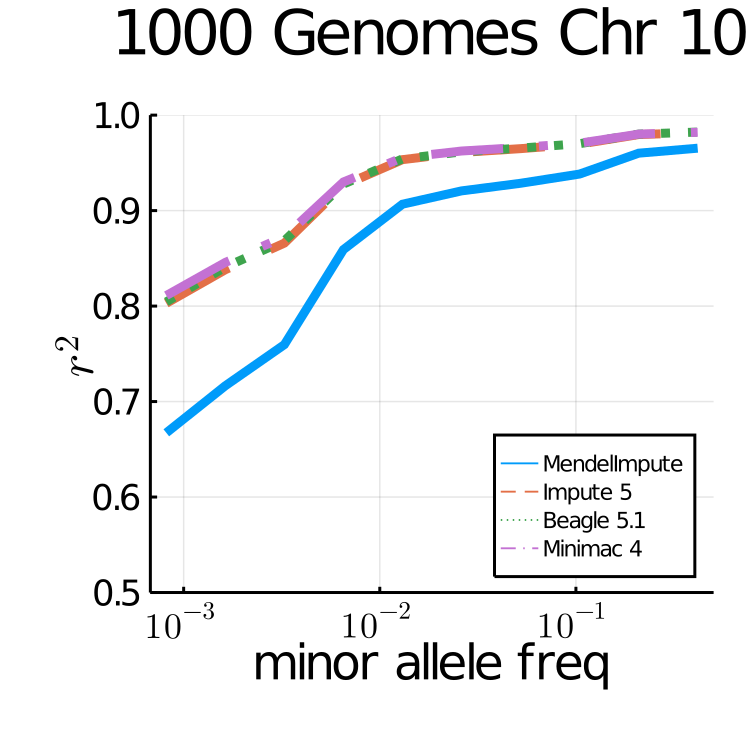

In [23]:
chr = 10
mafs = vec(readdlm("chr$chr.maf"))
n = nsamples("ref.chr$chr.vcf.gz")
minor_allele_count = mafs .* 2n
maf_bins = [2^i for i in 2:11]
xticks = ([1e-3, 1e-2, 1e-1], [latexstring("\$10^{-3}\$"),latexstring("\$10^{-2}\$"), latexstring("\$10^{-1}\$")])

r2_mendel = compute_r2_by_maf(minor_allele_count, Xtrue, Xmendel, verbose=true)
r2_impute5 = compute_r2_by_maf(minor_allele_count, Xtrue, Ximp5)
r2_beagle5 = compute_r2_by_maf(minor_allele_count, Xtrue, Xbeagle)
r2_mimimac4 = compute_r2_by_maf(minor_allele_count, Xtrue, Xmmac4)
sleep(1)

chr20_plt = plot(maf_bins ./ 2n, r2_mendel,label="MendelImpute", legend=:bottomright, lw = 3,
    xlabel="minor allele freq", ylabel=latexstring("\$r^2\$"), xaxis=:log, linestyle=:solid,
    xtick=xticks, dpi=300, size=(250, 250), ylim=(0.5, 1),
    title="1000 Genomes Chr 10",legendfontsize=5)
plot!(maf_bins ./ 2n, r2_impute5, label="Impute 5", lw = 3, linestyle=:dash,legendfontsize=5)
plot!(maf_bins ./ 2n, r2_beagle5, label="Beagle 5.1", lw = 3, linestyle=:dot,legendfontsize=5)
plot!(maf_bins ./ 2n, r2_mimimac4, label="Minimac 4", lw = 3, linestyle=:dashdot,legendfontsize=5)

savefig(chr20_plt, "chr$chr.maf_plt.png")
display("image/png", read("chr$chr.maf_plt.png"))